# TUTORIAL: Using an ESN to model the Lorenz 63

In [2]:
import parent_folders  # workaround path issue in jupyter notebook/lab


## 1. GENERATE THE TRAINING DATA

In [4]:
# Create training data from the Lorenz 63 model

from essentials.physical_models import Lorenz63



model = Lorenz63()

t_lyap = model.t_lyap

t_train = 40 * t_lyap
t_val = 6 * t_lyap
t_test = 20 * t_lyap


state, t = model.time_integrate(Nt=int((t_train + t_val + t_test)/model.dt))
model.update_history(state, t, reset=True)
    
model.close()


####  Add noise to the data 

In [6]:
import numpy as np

all_data = model.get_observable_hist()[...,0]

U_std = np.std(all_data, axis=1)
rng_noise = np.random.default_rng(0)
for dd in range(all_data.shape[1]):
    all_data[:, dd] += rng_noise.normal(loc=0, scale=0.5 * U_std[dd], size=all_data.shape[0])


N_tv = int((t_train+t_val)/model.dt)
train_data = all_data[:N_tv]
test_data = all_data[N_tv:]

#### Separate into train + validation and test datasets

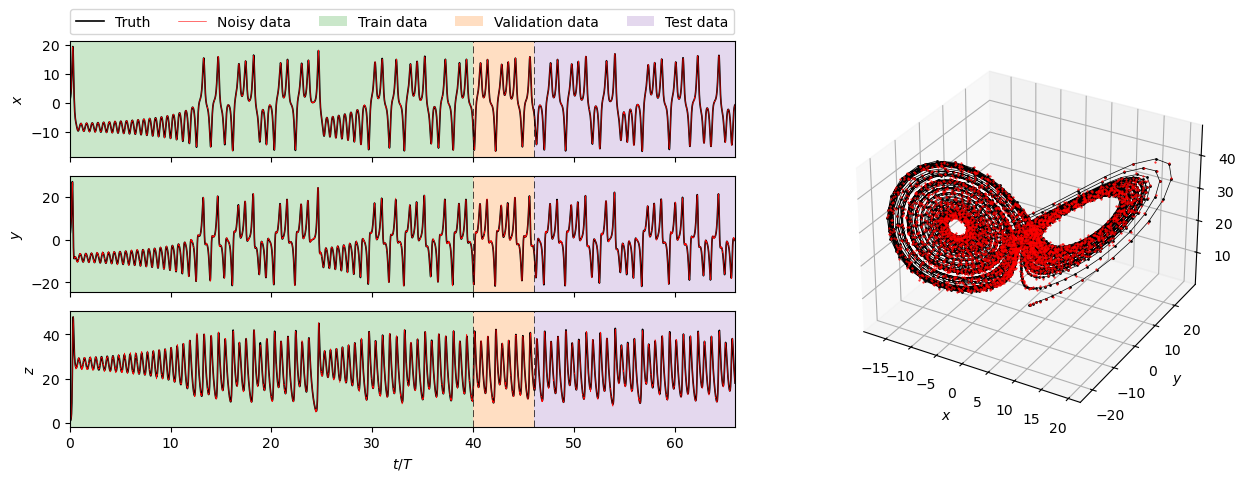

In [8]:
import matplotlib.pyplot as plt

# Visualize the training dataset
fig = plt.figure(figsize=(12.5, 5), layout='tight')
sfs = fig.subfigures(1, 2, width_ratios=[1.2,1])

axs = sfs[0].subplots(nrows=model.Nphi, ncols=1, sharex='col', sharey='row')
split_times = [0, t_train, t_val, t_test]
for axi, ax in enumerate(axs):
    ax.plot(model.hist_t/t_lyap, model.hist[:, axi], c='k', lw=1.2, label='Truth')
    ax.plot(model.hist_t/t_lyap, all_data[:, axi], c='r', lw=0.4,  label='Noisy data')
    for kk, c, lbl in zip(range(1,len(split_times)+1), ['C2', 'C1', 'C4'], ['Train', 'Validation', 'Test']):
        ax.axvspan(sum(split_times[:kk])/t_lyap, sum(split_times[:kk+1])/t_lyap, facecolor=c, alpha=0.25,  label=lbl+' data')
        ax.axvline(x=sum(split_times[:kk])/t_lyap, color='k', lw=0.5, dashes=[10, 5])
    ax.set(ylabel=model.obs_labels[axi])
    if axi == 0:
        ax.legend(loc='lower center', ncol=10, bbox_to_anchor=(0.5, 1.0))
axs[-1].set(xlabel='$t/T$', xlim=[0, model.hist_t[-1]/t_lyap]);


ax = sfs[1].add_subplot(111, projection='3d')
ax.plot(model.hist[:, 0],model.hist[:, 1],model.hist[:, 2], '.-', c='k', ms=2, lw=.5, label='Truth')
ax.plot(all_data[:, 0], all_data[:, 1], all_data[:, 2], '.', c='r', ms=1,  label='Noisy data')
ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$');

## 2. Initialize the ESN
NB: Different initializations result in different Wout.

In [364]:

from ML_models.EchoStateNetwork import EchoStateNetwork

# Define Echo state network parameters
ESN_params = dict(N_wash=5,  # Number of washout steps i.e., open-loop initialization
                  N_units=50,  # Number of neurons 
                  upsample=2, # We want the ESN to predict t + upsample * dt 
                  t_train=t_train,  # Training time
                  t_val=t_val, # Validation time
                  # Traioning-specific parameters
                  N_func_evals=40,
                  N_grid=5,
                  noise=1e-2,
                  Win_type='sparse',
                  N_folds=8,
                  N_split=5,
                  # Hyperparameter optimization ranges
                  rho_range=(.2, .8),
                  sigma_in_range=(np.log10(0.5), np.log10(50.)),
                  tikh_range=[1E-6, 1E-9, 1E-12],
                  )


# Initialize ESN class
ESN = EchoStateNetwork(y=np.zeros((3,1)), dt=model.dt, **ESN_params)


## 3. Train the ESN
The result of the ESN training is the output matrix.


 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 15 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-12	 -1.2743
2	 2.000e-01	 1.581e+00	 1.000e-06	 -0.8864
3	 2.000e-01	 5.000e+00	 1.000e-09	 -1.8714
4	 2.000e-01	 1.581e+01	 1.000e-06	 -0.4943
5	 2.000e-01	 5.000e+01	 1.000e-12	 -1.3184
6	 3.500e-01	 5.000e-01	 1.000e-06	 -0.8155
7	 3.500e-01	 1.581e+00	 1.000e-06	 -1.0771
8	 3.500e-01	 5.000e+00	 1.000e-06	 -1.5289
9	 3.500e-01	 1.581e+01	 1.000e-12	 -1.1674
10	 3.500e-01	 5.000e+01	 1.000e-12	 -1.3695
11	 5.000e-01	 5.000e-01	 1.000e-06	 -0.6262
12	 5.000e-01	 1.581e+00	 1.000e-06	 -0.9197
13	 5.000e-01	 5.000e+00	 1.000e-06	 -1.1088
14	 5.000e-01	 1.581e+01	 1.000e-12	 -1.1350
15	 5.000e-01	 5.000e+01	 1.000e-09	 -1.2207
16	 6.500e-01	 5.000e-01	 1.000e-06	 -0.6049
17	 6.500e-01	 1.581e+00	 1.000e-06	 -1.1514
18	 6.500e-01	 5.000e+00	 1.000e-09	 -1.1839
19	 6.500e-01	 1.581e+01	 1.000e-06	 -1.1353
20	 6.500

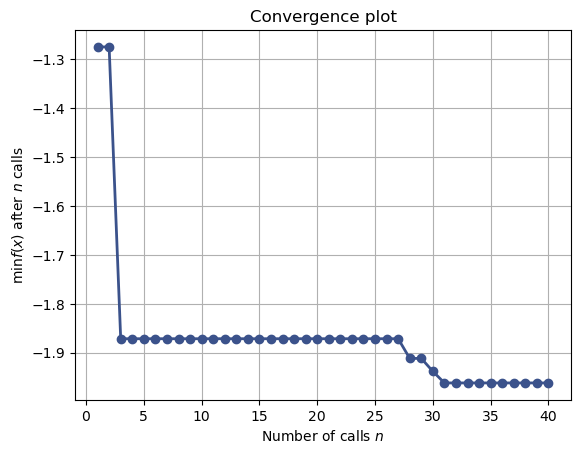

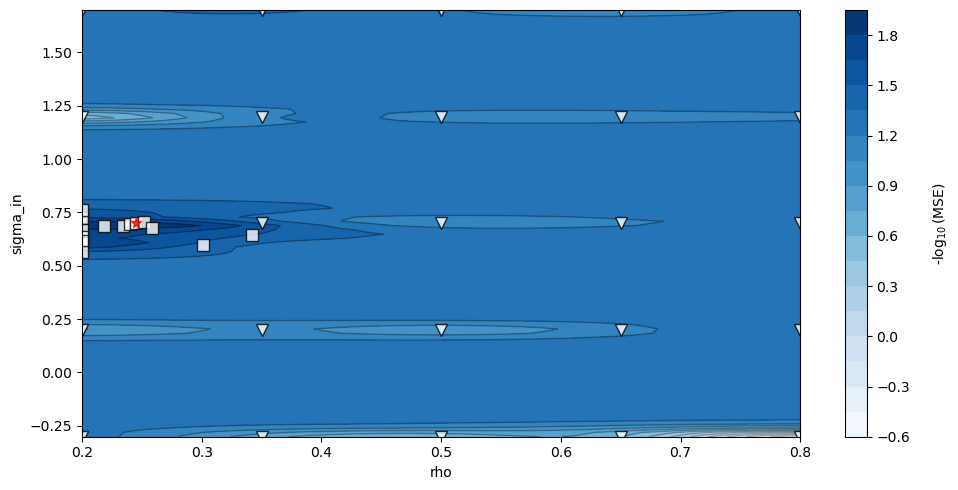

In [367]:
ESN.train(train_data, plot_train=True)

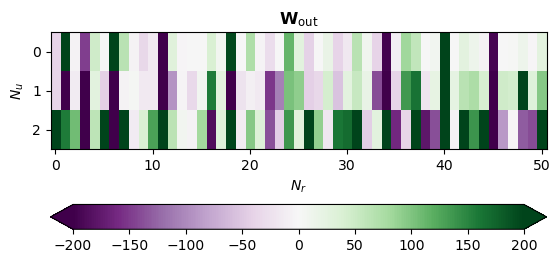

In [368]:
# Visualize the outout matrix
fig, ax = plt.subplots()
im = ax.matshow(ESN.Wout.T, cmap="PRGn", aspect=4., vmin=-200, vmax=200)
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
cbar=plt.colorbar(im, orientation='horizontal', extend='both')
ax.set(ylabel='$N_u$', xlabel='$N_r$', title='$\mathbf{W}_\mathrm{out}$');

## 4. Test the ESN predicion

In [370]:
test_data = all_data[N_tv:]

upsample_test_data = test_data[::ESN.upsample].copy() # Input


In [570]:
def run_test(closed_loop_time=t_lyap):
    
    number_of_tests = int(round(t_test / closed_loop_time))

    N_test = int(closed_loop_time // ESN.dt_ESN)

    # plot test
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[10, 2.5*ESN.N_dim], sharex='all', layout='tight')
    
    t_true = (np.arange(len(upsample_test_data)))* ESN.dt_ESN

    for dim_i, ax in zip(range(ESN.N_dim), axs):
        ax.plot(t_true/t_lyap, upsample_test_data[:, dim_i], '-k', lw=3, label=f'Clean data, "truth"')

    i0, err = 0, []
    while i0 < len(t_true):
        
        i1 = i0 + N_test  
        current_data = upsample_test_data[i0:i1].copy()
        current_time = t_true[i0:i1]
        
        U_wash = current_data[:ESN.N_wash+1]
        t_wash = current_time[:ESN.N_wash+1]
        
        Y_test = current_data[ESN.N_wash:] # Output to match
        t_closed = current_time[ESN.N_wash:]
    
        # Reset state (optional)
        # ESN.reset_state(u=np.zeros((ESN.N_dim,1)), r=np.zeros((ESN.N_units,1)))
        
        # initialize ESN with washout in open loop
        u_open, r_open = ESN.openLoop(U_wash)
        
        ESN.reset_state(u=u_open[-1], r=r_open[-1])
        
        # Closed-loop prediction
        Y_closed = ESN.closedLoop(len(Y_test))[0][1:,...,0]

        # compute error
        err.append(np.log10(np.mean((Y_closed - Y_test) ** 2) / np.mean(np.atleast_2d(ESN.norm ** 2))))
        
     
        for dim_i, ax, lbl in zip(range(ESN.N_dim), axs, ['x', 'y', 'z']):
            ax.plot(t_wash / t_lyap, u_open[:, dim_i], '-c', label=f'ESN open-loop prediction')
            ax.plot(t_wash[:-1]/ t_lyap, U_wash[:-1, dim_i], 'x', c='C4', ms=5, label=f'Washout')
            ax.plot(t_closed/ t_lyap, Y_closed[:, dim_i], '-r', label=f'ESN closed-loop prediction')
            ax.set(ylabel=f'${lbl}$')
        if i0 == 0:
            axs[0].legend(loc='lower center', ncol=10, bbox_to_anchor=(0.5, 1.0))
            axs[-1].set(xlabel='$t/T$')
        i0 += N_test 

    print(f'Test min, max and mean MSE in {number_of_tests} test = {min(err):.4}, {max(err):.4}, {np.mean(err):.4}.')

Test min, max and mean MSE in 40 test = -3.33, -1.984, -2.568.


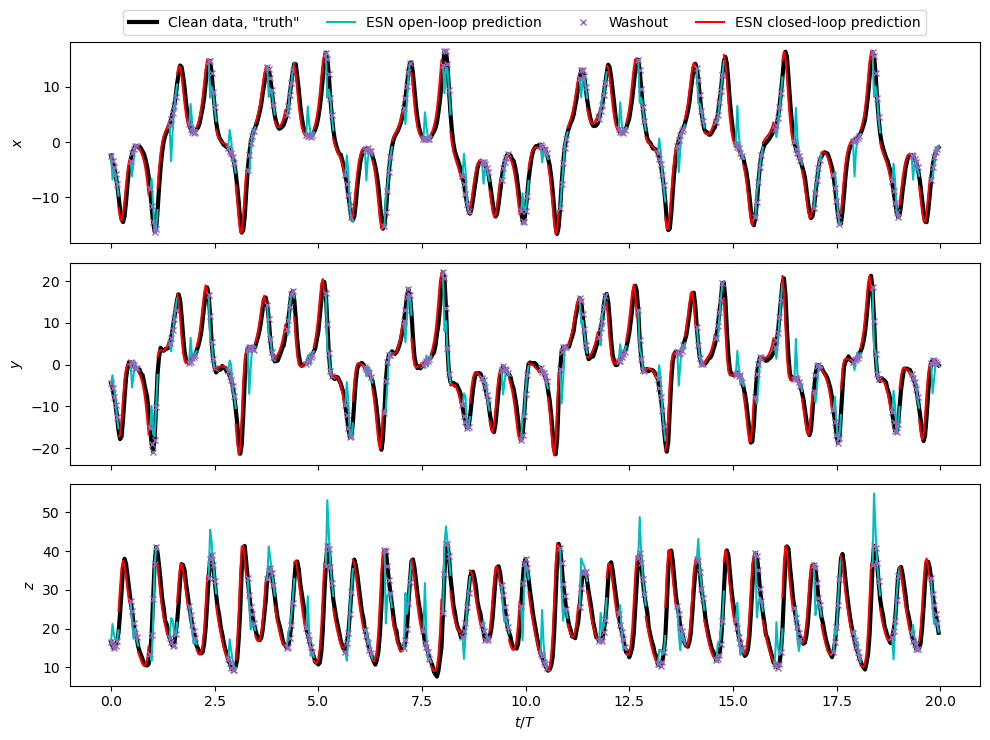

In [572]:

U_test = upsample_test_data.copy()

run_test(closed_loop_time=0.5*t_lyap)

Test min, max and mean MSE in 3 test = -2.421, -1.249, -1.698.


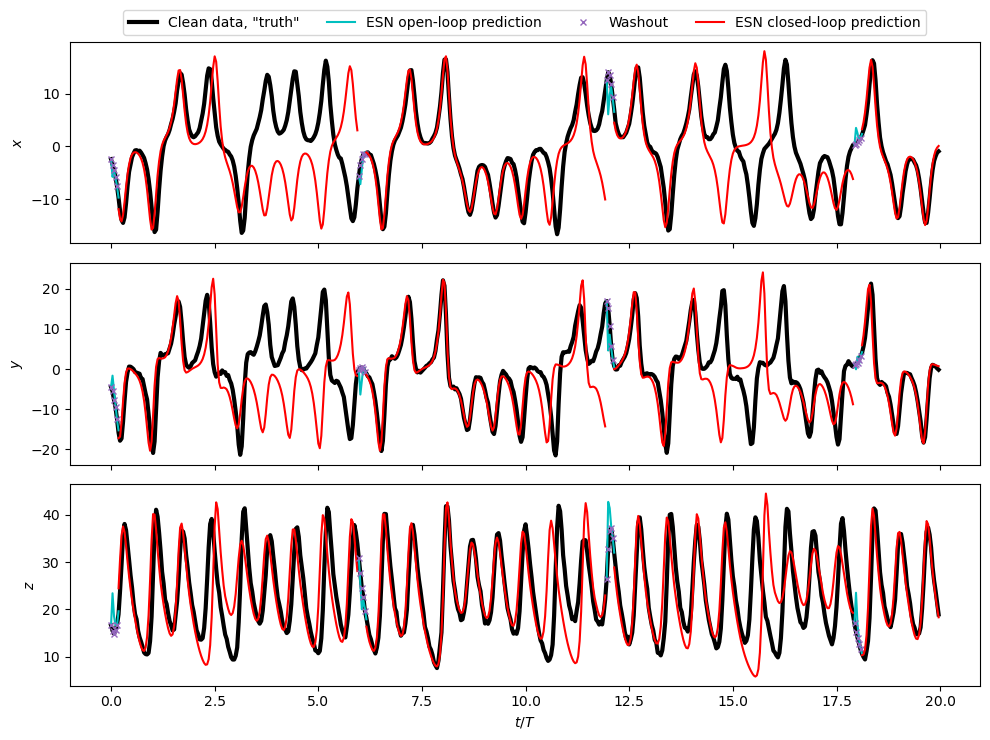

In [580]:

U_test = upsample_test_data.copy()

run_test(closed_loop_time=6*t_lyap)